In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('../raw_data/mbti_1.csv')
df.head(5)

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [3]:
import re

def clean_posts(text):
    # Split the tweets on ||||
    tweets = text.split("|||")
    cleaned = []

    for tweet in tweets:
        # Remove mentions
        tweet = re.sub(r'@\w+', '', tweet)
        # Remove URLs
        tweet = re.sub(r'http\S+', '', tweet)
        # Normalize unicode quotes and dashes (optional)
        tweet = tweet.replace('’', "'").replace('“', '"').replace('”', '"')
        # Keep basic punctuation, remove other non-letter characters
        tweet = re.sub(r'[^a-zA-Z0-9\s.,!?\'"]', '', tweet)
        # Remove extra whitespace
        tweet = re.sub(r'\s+', ' ', tweet).strip()
        # Lowercase
        tweet = tweet.lower()
        # Append only if not empty
        if tweet:
            cleaned.append(tweet)

    # Join tweets with a period and line break for readability
    return ". ".join(cleaned)

df['clean_text'] = df['posts'].apply(clean_posts)

In [4]:
custom_stopwords = {
    "intj", "intp", "entj", "entp",
    "infj", "infp", "enfj", "enfp",
    "istj", "isfj", "estj", "esfj",
    "istp", "isfp", "estp", "esfp",
    "intjs", "intps", "entjs", "entps",
    "infjs", "infps", "enfjs", "enfps",
    "istjs", "isfjs", "estjs", "esfjs",
    "istps", "isfps", "estps", "esfps"
}

# Création d'un pattern regex pour supprimer tous les mots MBTI
pattern = r'\b(?:' + '|'.join(re.escape(word) for word in custom_stopwords) + r')\b'

# Suppression dans la colonne 'clean_text' (insensible à la casse)
df['clean_text'] = df['clean_text'].str.replace(pattern, '', flags=re.IGNORECASE, regex=True)

# Suppression des espaces multiples (optionnel pour nettoyer)
df['clean_text'] = df['clean_text'].str.replace(r'\s+', ' ', regex=True).str.strip()

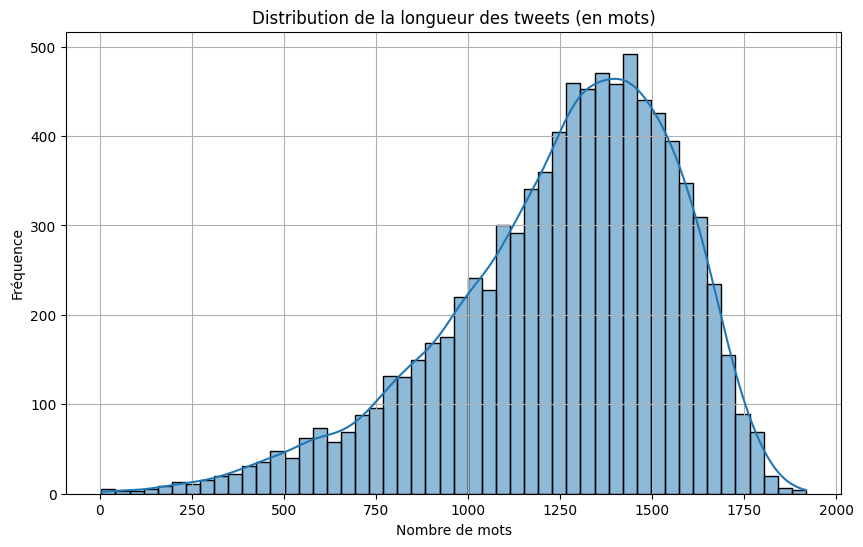

In [6]:
df['text_length_words'] = df['clean_text'].str.split().apply(len)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(df['text_length_words'], bins=50, kde=True)
plt.title("Distribution de la longueur des tweets (en mots)")
plt.xlabel("Nombre de mots")
plt.ylabel("Fréquence")
plt.grid(True)
plt.show()

In [7]:
df = df[df['clean_text'].apply(lambda x: len(x.split()) < 1700 and len(x.split()) > 1000)].reset_index(drop=True)

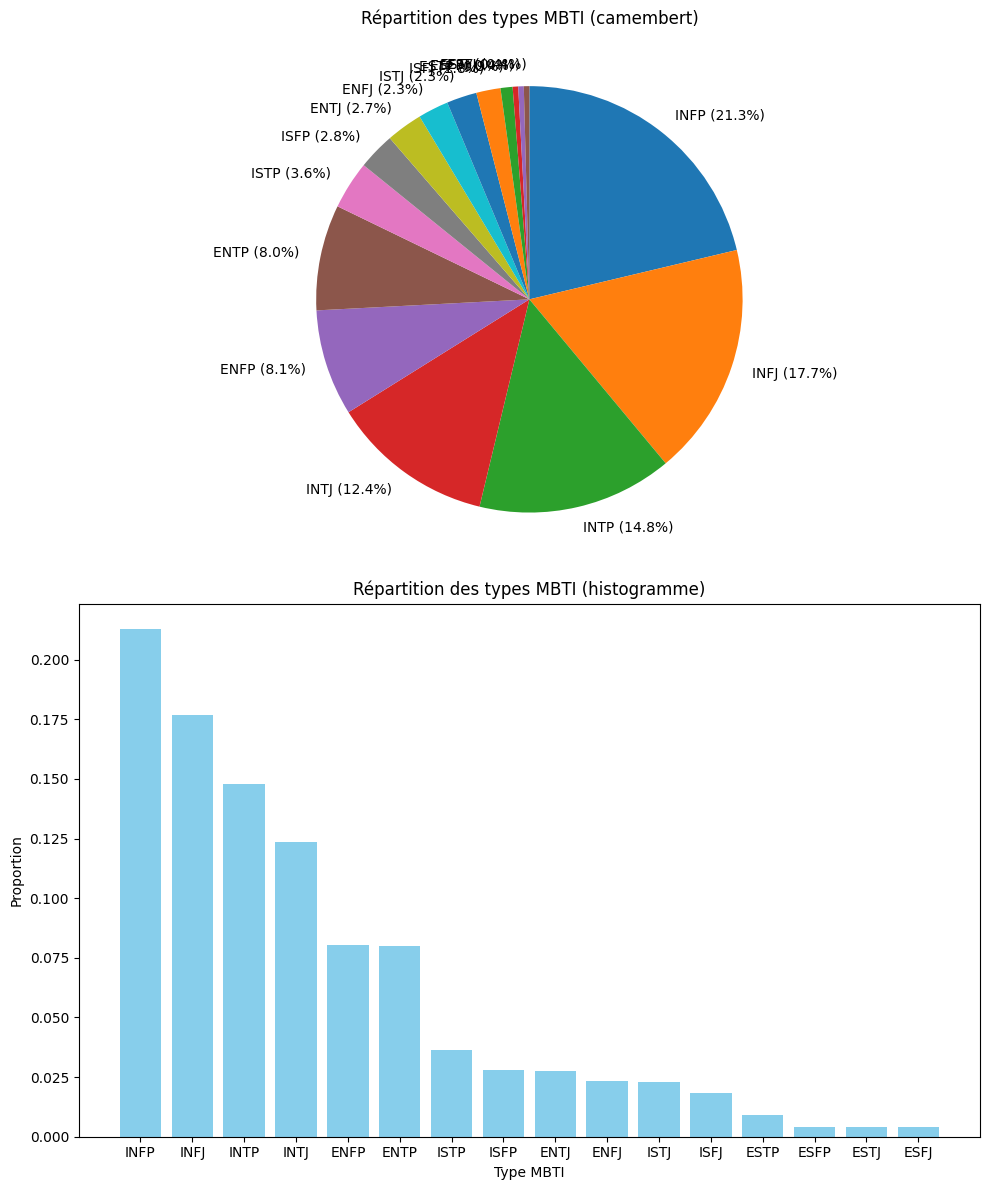

In [8]:
type_distribution = df['type'].value_counts(normalize=True).sort_values(ascending=False)

fig, axes = plt.subplots(2, 1, figsize=(10, 12))

# --- pie plot ---
axes[0].pie(
    type_distribution,
    labels=[f"{t} ({p*100:.1f}%)" for t, p in type_distribution.items()],
    autopct=None,
    startangle=90,
    counterclock=False
)
axes[0].set_title("Répartition des types MBTI (camembert)")

# --- Hist plot ---
axes[1].bar(type_distribution.index, type_distribution.values, color='skyblue')
axes[1].set_title("Répartition des types MBTI (histogramme)")
axes[1].set_ylabel("Proportion")
axes[1].set_xlabel("Type MBTI")

plt.tight_layout()
plt.show()

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6691 entries, 0 to 6690
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   type               6691 non-null   object
 1   posts              6691 non-null   object
 2   clean_text         6691 non-null   object
 3   text_length_words  6691 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 209.2+ KB


In [11]:
df['clean_text'][0]

"'i'm finding the lack of me in these posts very alarming.. sex can be boring if it's in the same position often. for example me and my girlfriend are currently in an environment where we have to creatively use cowgirl and missionary. there isn't enough.... giving new meaning to 'game' theory.. hello grin that's all it takes. than we converse and they do most of the flirting while i acknowledge their presence and return their words with smooth wordplay and more cheeky grins.. this lack of balance and hand eye coordination.. real iq test i score 127. internet iq tests are funny. i score 140s or higher. now, like the former responses of this thread i will mention that i don't believe in the iq test. before you banish.... you know you're an when you vanish from a site for a year and a half, return, and find people are still commenting on your posts and liking your ideasthoughts. you know you're an when you.... i over think things sometimes. i go by the old sherlock holmes quote. perhaps, 

In [12]:
# Create one binary column for each MBTI letter
df['IE'] = df['type'].apply(lambda x: 1 if x[0] == 'I' else 0)
df['NS'] = df['type'].apply(lambda x: 1 if x[1] == 'N' else 0)
df['TF'] = df['type'].apply(lambda x: 1 if x[2] == 'T' else 0)
df['JP'] = df['type'].apply(lambda x: 1 if x[3] == 'J' else 0)

In [13]:
print(f"balance of the target ie : {df['IE'].value_counts(normalize=True)}")
print(f"balance of the target ns :{df['NS'].value_counts(normalize=True)}")
print(f"balance of the target tf :{df['TF'].value_counts(normalize=True)}")
print(f"balance of the target jp :{df['JP'].value_counts(normalize=True)}")

balance of the target ie : IE
1    0.767
0    0.233
Name: proportion, dtype: float64
balance of the target ns :NS
1    0.872515
0    0.127485
Name: proportion, dtype: float64
balance of the target tf :TF
0    0.548199
1    0.451801
Name: proportion, dtype: float64
balance of the target jp :JP
0    0.599313
1    0.400687
Name: proportion, dtype: float64


In [14]:
!pip install xgboost --q

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

In [16]:
vectorizer = TfidfVectorizer(max_features=20000,
                             ngram_range=(1, 2),
                             stop_words=list(ENGLISH_STOP_WORDS)
                             )

X = vectorizer.fit_transform(df["clean_text"])

In [17]:
y_ie = df["IE"]
X_train_ie, X_test_ie, y_train_ie, y_test_ie = train_test_split(X, y_ie, test_size=0.2, random_state=42)
model_ie = XGBClassifier(eval_metric='logloss')
model_ie.fit(X_train_ie, y_train_ie)
y_pred_ie = model_ie.predict(X_test_ie)
print(classification_report(y_test_ie, y_pred_ie))

              precision    recall  f1-score   support

           0       0.54      0.14      0.22       318
           1       0.78      0.96      0.86      1021

    accuracy                           0.77      1339
   macro avg       0.66      0.55      0.54      1339
weighted avg       0.72      0.77      0.71      1339



In [18]:
# Get feature importances
importances_ie = model_ie.feature_importances_  # shape: (num_features,)

# Get the vocabulary (i.e., words) from the vectorizer
feature_names_ie = vectorizer.get_feature_names_out()

# Combine words with importances
word_importances_ie = list(zip(feature_names_ie, importances_ie))

# Sort by importance
word_importances_ie = sorted(word_importances_ie, key=lambda x: x[1], reverse=True)

# Show top 20 most important words
for word, importance in word_importances_ie[:20]:
    print(f"{word}: {importance:.4f}")

fuck: 0.0056
7w8: 0.0056
jump: 0.0051
introverted extroverts: 0.0048
agreed: 0.0045
hey guys: 0.0045
teach: 0.0042
choices: 0.0041
grounded: 0.0041
persona: 0.0041
holding: 0.0040
trait: 0.0039
misread: 0.0039
ve said: 0.0039
nts: 0.0037
focused: 0.0037
omg: 0.0036
vague: 0.0035
rational: 0.0034
right wrong: 0.0034


In [19]:
y_ns = df["NS"]
X_train_ns, X_test_ns, y_train_ns, y_test_ns = train_test_split(X, y_ns, test_size=0.2, random_state=42)
model_ns = XGBClassifier(eval_metric='logloss')
model_ns.fit(X_train_ns, y_train_ns)
y_pred_ns = model_ns.predict(X_test_ns)
print(classification_report(y_test_ns, y_pred_ns))

              precision    recall  f1-score   support

           0       0.50      0.04      0.07       174
           1       0.87      0.99      0.93      1165

    accuracy                           0.87      1339
   macro avg       0.69      0.52      0.50      1339
weighted avg       0.83      0.87      0.82      1339



In [20]:
# Get feature importances
importances_ns = model_ns.feature_importances_  # shape: (num_features,)

# Get the vocabulary (i.e., words) from the vectorizer
feature_names_ns = vectorizer.get_feature_names_out()

# Combine words with importances
word_importances_ns = list(zip(feature_names_ns, importances_ns))

# Sort by importance
word_importances_ns = sorted(word_importances_ns, key=lambda x: x[1], reverse=True)

# Show top 20 most important words
for word, importance in word_importances_ns[:20]:
    print(f"{word}: {importance:.4f}")

rave: 0.0117
lazy: 0.0085
inferior ne: 0.0079
snowboarding: 0.0075
tini: 0.0068
friendly: 0.0063
genres: 0.0062
bull: 0.0059
keys: 0.0053
combined: 0.0052
battery: 0.0051
buddies: 0.0051
human: 0.0050
pilot: 0.0050
angry: 0.0049
jobs: 0.0049
sounds like: 0.0048
niss: 0.0048
people aren: 0.0047
body: 0.0045


In [21]:
y_tf = df["TF"]
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(X, y_tf, test_size=0.2, random_state=42)
model_tf = XGBClassifier(eval_metric='logloss')
model_tf.fit(X_train_tf, y_train_tf)
y_pred_tf = model_tf.predict(X_test_tf)
print(classification_report(y_test_tf, y_pred_tf))

              precision    recall  f1-score   support

           0       0.73      0.82      0.77       710
           1       0.76      0.66      0.71       629

    accuracy                           0.74      1339
   macro avg       0.75      0.74      0.74      1339
weighted avg       0.75      0.74      0.74      1339



In [22]:
# Get feature importances
importances_tf = model_tf.feature_importances_  # shape: (num_features,)

# Get the vocabulary (i.e., words) from the vectorizer
feature_names_tf = vectorizer.get_feature_names_out()

# Combine words with importances
word_importances_tf = list(zip(feature_names_tf, importances_tf))

# Sort by importance
word_importances_tf = sorted(word_importances_tf, key=lambda x: x[1], reverse=True)

# Show top 20 most important words
for word, importance in word_importances_tf[:20]:
    print(f"{word}: {importance:.4f}")

love: 0.0062
bullshit: 0.0051
article: 0.0042
feel: 0.0042
beautiful: 0.0041
identify: 0.0039
4w3: 0.0038
4w5: 0.0037
degree: 0.0037
stupid just: 0.0036
enjoyable: 0.0035
watched: 0.0034
emotional people: 0.0034
smoke: 0.0034
technical: 0.0033
waste: 0.0033
people tend: 0.0033
happy: 0.0033
feeling: 0.0033
gender: 0.0033


In [23]:
y_jp = df["JP"]
X_train_jp, X_test_jp, y_train_jp, y_test_jp = train_test_split(X, y_jp, test_size=0.2, random_state=42)
model_jp = XGBClassifier(eval_metric='logloss')
model_jp.fit(X_train_jp, y_train_jp)
y_pred_jp = model_jp.predict(X_test_jp)
print(classification_report(y_test_jp, y_pred_jp))

              precision    recall  f1-score   support

           0       0.68      0.80      0.74       800
           1       0.60      0.45      0.51       539

    accuracy                           0.66      1339
   macro avg       0.64      0.62      0.62      1339
weighted avg       0.65      0.66      0.65      1339



In [24]:
# Get feature importances
importances_jp = model_jp.feature_importances_  # shape: (num_features,)

# Get the vocabulary (i.e., words) from the vectorizer
feature_names_jp = vectorizer.get_feature_names_out()

# Combine words with importances
word_importances_jp = list(zip(feature_names_jp, importances_jp))

# Sort by importance
word_importances_jp = sorted(word_importances_jp, key=lambda x: x[1], reverse=True)

# Show top 20 most important words
for word, importance in word_importances_jp[:20]:
    print(f"{word}: {importance:.4f}")

rave: 0.0046
ni: 0.0044
recall: 0.0042
quality: 0.0036
ne: 0.0032
weed: 0.0032
understood: 0.0032
input: 0.0031
meet: 0.0030
quality time: 0.0030
si: 0.0029
japanese: 0.0028
fuck: 0.0028
6w5: 0.0028
sorta: 0.0028
beautiful: 0.0028
90: 0.0027
trusting: 0.0027
dear: 0.0027
buy: 0.0027


In [25]:
ie_pred = ['i' if x == 1 else 'e' for x in y_pred_ie]
ns_pred = ['n' if x == 1 else 's' for x in y_pred_ns]
tf_pred = ['t' if x == 1 else 'f' for x in y_pred_tf]
jp_pred = ['j' if x == 1 else 'p' for x in y_pred_jp]

y_test_ie_l = ['i' if x == 1 else 'e' for x in y_test_ie]
y_test_ns_l = ['n' if x == 1 else 's' for x in y_test_ns]
y_test_tf_l = ['t' if x == 1 else 'f' for x in y_test_tf]
y_test_jp_l = ['j' if x == 1 else 'p' for x in y_test_jp]

In [26]:
# Create DataFrame
df_pred = pd.DataFrame({
    'IE': ie_pred,
    'NS': ns_pred,
    'TF': tf_pred,
    'JP': jp_pred,
    'IE_test': y_test_ie_l,
    'NS_test': y_test_ns_l,
    'TF_test': y_test_tf_l,
    'JP_test': y_test_jp_l
})

df_pred['MBTI'] = df_pred['IE'] + df_pred['NS'] + df_pred['TF'] + df_pred['JP']
df_pred['MBTI_test'] = df_pred['IE_test'] + df_pred['NS_test'] + df_pred['TF_test'] + df_pred['JP_test']

In [27]:
accuracy = (df_pred['MBTI'] == df_pred['MBTI_test']).mean() * 100

print(f"Pourcentage de MBTI correctement prédits : {accuracy:.2f}%")

Pourcentage de MBTI correctement prédits : 32.11%


In [28]:
accuracy_ie = (df_pred['IE'] == df_pred['IE_test']).mean() * 100
accuracy_ns = (df_pred['NS'] == df_pred['NS_test']).mean() * 100
accuracy_tf = (df_pred['TF'] == df_pred['TF_test']).mean() * 100
accuracy_jp = (df_pred['JP'] == df_pred['JP_test']).mean() * 100


print(f"Pourcentage de IE correctement prédits : {accuracy_ie:.2f}%")
print(f"Pourcentage de NS correctement prédits : {accuracy_ns:.2f}%")
print(f"Pourcentage de TF correctement prédits : {accuracy_tf:.2f}%")
print(f"Pourcentage de JP correctement prédits : {accuracy_jp:.2f}%")

Pourcentage de IE correctement prédits : 76.70%
Pourcentage de NS correctement prédits : 87.01%
Pourcentage de TF correctement prédits : 74.46%
Pourcentage de JP correctement prédits : 65.72%


In [ ]:
print(f"balance of the target ie : {df['IE'].value_counts(normalize=True)}")
print(f"balance of the target ns :{df['NS'].value_counts(normalize=True)}")
print(f"balance of the target tf :{df['TF'].value_counts(normalize=True)}")
print(f"balance of the target jp :{df['JP'].value_counts(normalize=True)}")